In [1]:
import torchvision
import matplotlib

In [2]:
%matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [3]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            # we 'detach' the target content from the tree used
            # to dynamically compute the gradient: this is a stated value,
            # not a variable. Otherwise the forward method of the criterion
            # will throw an error.
            self.target = target.detach()#это константа. Убираем ее из дерева вычеслений
            self.loss = F.mse_loss(self.target, self.target )#to initialize with something

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

In [4]:
def gram_matrix(input):
        batch_size , h, w, f_map_num = input.size()  # batch size(=1)
        # b=number of feature maps
        # (h,w)=dimensions of a feature map (N=h*w)

        features = input.view(batch_size * h, w * f_map_num)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(batch_size * h * w * f_map_num)

In [5]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature):
            super(StyleLoss, self).__init__()
            self.target = gram_matrix(target_feature).detach()
            self.loss = F.mse_loss(self.target, self.target)# to initialize with something

        def forward(self, input):           
            G = gram_matrix(input)
            self.loss = F.mse_loss(G, self.target)
            return input

In [6]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

In [7]:
#torch.autograd.set_detect_anomaly(True)
unloader = transforms.ToPILImage() # тензор в кратинку  

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

# отрисовка

#plt.figure()
#imshow(style_img, title='Style Image') # тензор в кратинку

In [8]:
class StyleTransfer():
    def __init__(self, style_image_path, content_image_path):
        imsize = 256
        #self.loader = None
        self.loader = transforms.Compose([transforms.Resize(imsize),  # нормируем размер изображения
                                        transforms.CenterCrop(imsize),
                                        transforms.ToTensor()])  # превращаем в удобный формат

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        

        self.style_img = self.image_loader(style_image_path)# as well as here
        self.content_img = self.image_loader(content_image_path)#измените путь на тот который у вас.
        # отрисовка

        self.cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(self.device)
        self.cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(self.device)

        
        self.cnn =models.alexnet(pretrained=True).features.to(self.device).eval()

        self.content_layers_default = ['conv_4']
        
        self.style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

    def __del__(self):
      # body of destructor
      if torch.cuda.is_available() == True:
        del self.cnn
        del self.cnn_normalization_mean
        del self.cnn_normalization_std

        del self.style_img
        del self.content_img


        torch.cuda.empty_cache()


    def image_loader(self, image_name):
        image = Image.open(image_name)
        image = self.loader(image).unsqueeze(0)
        return image.to(self.device, torch.float)

    def get_style_model_and_losses(self, cnn, normalization_mean, normalization_std,
                                    style_img, content_img):
        cnn = copy.deepcopy(cnn)
        content_layers = self.content_layers_default
        style_layers = self.style_layers_default

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(self.device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_losses = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).detach()
                style_loss = StyleLoss(target_feature)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

          # now we trim off the layers after the last content and style losses
          #выбрасываем все уровни после последенего styel loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

    def get_input_optimizer(self, input_img):
        # this line to show that input is a parameter that requires a gradient
        #добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

   #un_style_transfer(cnn, normalization_mean, normalization_std,  content_img, style_img, input_img, num_steps=400, style_weight=5000, content_weight=1):
    def run_style_transfer(self, cnn, normalization_mean, normalization_std,
                          content_img, style_img, input_img, num_steps=550,
                        style_weight=5000, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, content_losses = self.get_style_model_and_losses(cnn,normalization_mean, normalization_std, style_img, content_img)
        optimizer = self.get_input_optimizer(input_img)
        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:
            def closure():
                # correct the values
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss

                #взвешивание ощибки
                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                return style_score + content_score

            optimizer.step(closure)

          # a last correction...
        input_img.data.clamp_(0, 1)
        del model

        return input_img

    def transfer_style(self, out_image_path):
        input_img = self.content_img.clone()
    # if you want to use white noise instead uncomment the below line:
    #input_img = torch.randn(content_img.data.size(), device=device)

    # add the original input image to the figure:

        output = self.run_style_transfer(self.cnn, self.cnn_normalization_mean, self.cnn_normalization_std,
                                self.content_img, self.style_img, input_img)



        unloader = transforms.ToPILImage() # тензор в кратинку
        out_image = output.cpu().clone()
        out_image = out_image.squeeze(0)
        out_image = unloader(out_image)
        out_image.save(out_image_path)

        del input_img
        return out_image

In [9]:
object_style_transfer = StyleTransfer(style_image_path='examples/shishkin.JPG',
                                                    content_image_path='examples/wood.JPG')

Building the style transfer model..
Optimizing..

C:\Users\albin\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
C:\Users\albin\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  



run [50]:
Style Loss : 13.767799 Content Loss: 10.373993

run [100]:
Style Loss : 9.734179 Content Loss: 9.293148

run [150]:
Style Loss : 8.094521 Content Loss: 8.851885

run [200]:
Style Loss : 7.301300 Content Loss: 8.656507

run [250]:
Style Loss : 6.785562 Content Loss: 8.541718

run [300]:
Style Loss : 6.469900 Content Loss: 8.487575

run [350]:
Style Loss : 6.199421 Content Loss: 8.398370

run [400]:
Style Loss : 6.025934 Content Loss: 8.370265

run [450]:
Style Loss : 5.858322 Content Loss: 8.297534

run [500]:
Style Loss : 5.714197 Content Loss: 8.257900

run [550]:
Style Loss : 6.932972 Content Loss: 8.167274



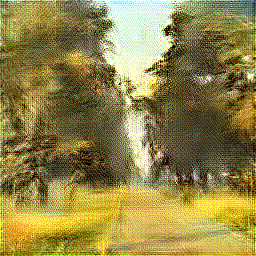

In [10]:
out_image_ex =object_style_transfer.transfer_style(out_image_path= "examples/shishkin_wood550.jpg")
out_image_ex